# Contextuailzed Embeddings
Having a dataframe of sentences that contain a term, create the contextualized embeddings of the uses of that term in the sentences with a transformers model.

In [1]:
import os
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the language model

In [3]:
path2model = os.path.join(os.pardir, os.pardir, "histLM", "histLM_dataset", "bert", "bert_1760_1900")
tokenizer = "bert-base-uncased"

In [4]:
model = pipeline("feature-extraction", 
                    model=path2model, 
                    tokenizer=tokenizer)

## Load the sentences

In [65]:
datapath = '../../sentences_out'

term = 'fair'
df_sentences = pd.read_csv(os.path.join(datapath, term+'.csv'))

In [66]:
df_sentences['sentence_lc'] = df_sentences['sentence'].str.lower()

In [67]:
print(df_sentences.shape)
df_sentences.head()

(425, 5)


,year,genre,id,sentence,sentence_lc
0,1889,news,672250,Because of the revolutionary character of the ...,because of the revolutionary character of the ...
1,1889,news,672250,"It has been observed , of course , that the No...","it has been observed , of course , that the no..."
2,1889,news,672250,"Originally , the Post 's opposition to the fai...","originally , the post 's opposition to the fai..."
3,1889,news,672250,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...
4,1889,news,672250,about the fair .,about the fair .


## Apply model to get embeddings
This will take some time to run

In [68]:
# embedding on each sentence
embeddings = model(list(df_sentences['sentence_lc']))

In [69]:
def get_word_embeddings(embedding, sentence, query):
    """
    Only retrieve the embeddings for the tokens that match the query
    Does not yet handle the case where query is split up in tokenization.
    """
    token_ids = model.tokenizer(sentence)
    tokens = model.tokenizer.convert_ids_to_tokens(token_ids['input_ids'])
    query_embeddings = np.array([embedding[i] for i,tok in enumerate(tokens) if tok==query])
    return query_embeddings

In [70]:
# Now do this for all sentences, and put them together in a dataframe
df_embeddings = pd.DataFrame()
for i, (_, row) in enumerate(df_sentences.iterrows()):
    emb = get_word_embeddings(embeddings[i], row['sentence_lc'], term)
    df_embeddings = df_embeddings.append(pd.DataFrame({
        'sentence': row['sentence'],
        'sentence_lc': row['sentence_lc'],
        'year': row['year'],
        'genre': row['genre'],
        'id': row['id'],
        'embedding': list(emb)}))

In [71]:
df_embeddings = df_embeddings.reset_index()

## Plot PCA

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca = PCA(n_components=2)

In [74]:
X = np.array([e for e in df_embeddings['embedding']])
X.shape

(433, 768)

In [75]:
X_pca = pca.fit_transform(X)

In [76]:
df_embeddings['pca1'] = X_pca[:,0]
df_embeddings['pca2'] = X_pca[:,1]

Text(0.5, 1.0, 'PCA colored per genre')

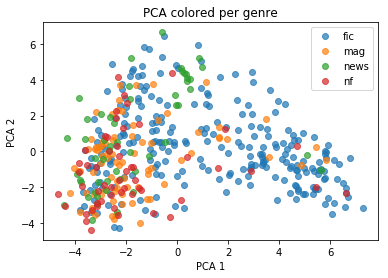

In [77]:
for key, group in df_embeddings.groupby(['genre']):
    plt.plot(group.pca1, group.pca2, 'o', alpha=0.7, label=key)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("PCA colored per genre")

Text(0.5, 1.0, 'PCA colored per year')

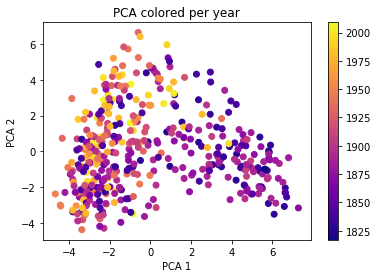

In [78]:
plt.scatter(df_embeddings['pca1'], df_embeddings['pca2'], c=df_embeddings['year'], cmap='plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.title("PCA colored per year")

## Plot TSNE embedding

In [79]:
from sklearn.manifold import TSNE

In [80]:
X_tsne = TSNE(n_components=2, init='pca').fit_transform(X)
df_embeddings['tsne1'] = X_tsne[:,0]
df_embeddings['tsne2'] = X_tsne[:,1]

Text(0.5, 1.0, 'tsne colored per genre')

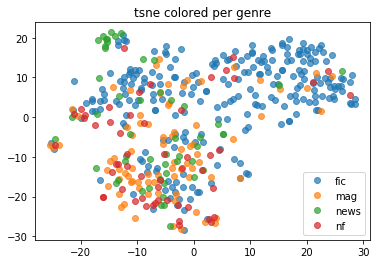

In [81]:
for key, group in df_embeddings.groupby(['genre']):
    plt.plot(group.tsne1, group.tsne2, 'o', alpha=0.7, label=key)
plt.legend()
plt.title("tsne colored per genre")

Text(0.5, 1.0, 'tsne colored per year')

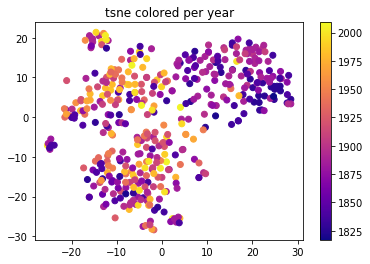

In [82]:
plt.scatter(df_embeddings['tsne1'], df_embeddings['tsne2'], c=df_embeddings['year'], cmap='plasma')
plt.colorbar()
plt.title("tsne colored per year")

## Masked word prediction
We mask the original term, and see what the model predicts instead.

In [83]:
model_masked = pipeline('fill-mask',
                           model=path2model, 
                    tokenizer=tokenizer)

In [85]:
outputs = []

for i in range(len(df_sentences)):
    sent = df_sentences['sentence_lc'][i]
    sent_masked = sent.replace(term, '[MASK]', 1)
    output = model_masked(sent_masked)
    outputs.append(output)
    

predicted_words = [[o['token_str'] for o in output] for output in outputs]

In [86]:
predicted_words_df = pd.DataFrame(predicted_words, columns = ['word_{}'.format(i+1) for i in range(5)])
df = pd.concat([df_sentences, predicted_words_df], axis=1)

In [87]:
predicted_words_df.head()

,word_1,word_2,word_3,word_4,word_5
0,review,.,journal,times,exposition
1,events,proceedings,date,census,action
2,fair,plan,park,scheme,project
3,sufficient,satisfactory,correct,accurate,a
4,same,month,middle,time,town


In [88]:

df.head()

,year,genre,id,sentence,sentence_lc,word_1,word_2,word_3,word_4,word_5
0,1889,news,672250,Because of the revolutionary character of the ...,because of the revolutionary character of the ...,review,.,journal,times,exposition
1,1889,news,672250,"It has been observed , of course , that the No...","it has been observed , of course , that the no...",events,proceedings,date,census,action
2,1889,news,672250,"Originally , the Post 's opposition to the fai...","originally , the post 's opposition to the fai...",fair,plan,park,scheme,project
3,1889,news,672250,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,sufficient,satisfactory,correct,accurate,a
4,1889,news,672250,about the fair .,about the fair .,same,month,middle,time,town


In [89]:
# What words are predicted most often?
all_words = pd.concat([df['word_{}'.format(i+1)] for i in range(5)])
all_words.value_counts().head(30)

fair          185
good           68
the            34
great          29
beautiful      26
little         26
right          26
.              25
just           21
full           21
large          21
a              21
own            20
true           18
high           17
reasonable     17
clear          17
young          16
proper         16
free           15
bright         14
lovely         14
plain          14
,              13
new            13
due            12
other          12
well           12
better         12
fine           12
dtype: int64

In [92]:
# The most typical sentences: where <term> was also predicted first
df[df['word_1']==term][['sentence']+['word_{}'.format(i+1) for i in range(5)]]

,sentence,word_1,word_2,word_3,word_4,word_5
2,"Originally , the Post 's opposition to the fai...",fair,plan,park,scheme,project
12,Its political opponents have shown a dispositi...,fair,free,open,full,foul
13,He further expressed the sentiment of that ind...,fair,free,full,competent,public
14,The general hopefulness and good-will with whi...,fair,promise,hope,it,speed
15,Raymond He -- A base born Pirate -- grov'l...,fair,glorious,immortal,proud,bright
18,Rumour reports thee fairest of the fair -- w...,fair,the,",",high,beau
20,Alexius Hear me but @ @ @ @ @ @ @ @ @ @ is my ...,fair,young,captive,poor,unfortunate
23,"Go and tell your master , that Tancred hath no...",fair,captive,lady,young,turkish
27,Wherein mine honour is with his entwined -- ...,fair,lovely,faithful,young,turkish
30,"Herald You Raymond Count of Thoulouse , furthe...",fair,captive,turkish,young,faithful


In [91]:
df.to_csv('../../sentences_out/{}_embedded_histlm.csv'.format(term))